# Implement efficient DTW for a faster and more accurate sim search


In [1]:
!pip install ucrdtw

Cleaning up...


In [9]:
#!cat /project/python/lib/ml/simsearch.py

In [10]:
# -*- coding: utf-8 -*-

import logging
import time
import copy
import json
import _ucrdtw
import histdata
from multiprocessing import Pool, TimeoutError

logger = logging.getLogger(__name__)


def _remove_duplicates(features):
    ret = []
    cache = set()
    for feat in features:
        tmp = copy.copy(feat)
        tmp.pop('id')
        key = json.dumps(tmp, sort_keys=True)
        if key not in cache:
            ret.append(feat)
            cache.add(key)
    return ret


def _remove_normalizers(features):
    ret = []
    for feat in features:
        if 'normalizers' in feat:
            feat.pop('normalizers')
        ret.append(feat)
    return ret


def split(df, fold=5):
    ret = []
    lenght = len(df)
    for i in range(fold):
        ret.append(df[i * lenght / fold:lenght / fold * (i + 1)])
    return ret


def search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5):

    if k_nearest > 16:
        k_nearest = 16
        logger.warning("Capped to 16 k_nearest results")

    extend_by = 10

    s = time.time()

    df = histdata.pandadb[
        histdata.get_table_name(mp['symbol'], mp['timeframe'])]
    tmp_df = df[start:]
    try:
        tmp_end = max(tmp_df.index.get_loc(end), 10)
    except KeyError:
        tmp_end = max(tmp_df.index.get_loc(end, method="bfill"), 10)
    selected_range = tmp_df.iloc[:tmp_end + extend_by + 1]
    range_size = selected_range.shape[0]

    splits = k_nearest
    shift = len(df) - range_size * samples

    df = df[shift:]

    data = df[["close", "high", "low", "open"]].values
    query = selected_range[["close", "high", "low", "open"]].values

    sp = split(data, fold=splits)

    idx = []

    pool = Pool(k_nearest)
    dic = {}
    for i in range(splits):
        dic["result%d" % i] = pool.apply_async(
            _ucrdtw.ucrdtw, [sp[i], query, 0.1, False])

    for i in dic.iteritems():
        try:
            loc, dist = i[1].get(timeout=3)
            idx.append({
                'start': df.ix[loc].name,
                'end': df.ix[loc + range_size - extend_by].name,
                'distance': dist,
                'num_candles': range_size - extend_by
            })
        except TimeoutError:
            pass

    pool.close()
    pool.terminate()
    pool.join()

    logger.info("elapsed time Fast DTW: {}".format(time.time() - s))

    return sorted(idx, key=lambda sugg: sugg[
                  "start"].toordinal(), reverse=True)

In [11]:
%%timeit
# "201402041452","start":"201402041332
start, end = "2014-02-04 14:50:00" , "2014-02-04 12:55:00"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"
ret = search(mp,start,end, samples=10000, k_nearest=5)

1 loop, best of 3: 700 ms per loop


In [4]:
from __future__ import print_function
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

In [5]:
mp = load_json("/project/exp/list_mp.json")

In [ ]:
#def search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5):
samples=10000
pca_dim=32
k_nearest=5

if k_nearest > 16:
    k_nearest = 16
    logger.warning("Capped to 16 k_nearest results")

extend_by = 10
print("ok 0")
s = time.time()

df = histdata.pandadb[
    histdata.get_table_name(mp['symbol'], mp['timeframe'])]
print("ok 1")
tmp_df = df[start:]
tmp_end = max(tmp_df.index.get_loc(end), 10)
selected_range = tmp_df.iloc[:tmp_end + extend_by + 1]
range_size = selected_range.shape[0]
print("ok 2")
splits = k_nearest
shift = len(df) - range_size * samples

df = df[shift:]

data = df[["close", "high", "low", "open"]].values
query = selected_range[["close", "high", "low", "open"]].values

sp = split(data, fold=splits)

idx = []

pool = Pool(k_nearest)
dic = {}
for i in range(splits):
    dic["result%d" % i] = pool.apply_async(
        _ucrdtw.ucrdtw, [sp[i], query, 0.1, False])

for i in dic.iteritems():
    try:
        loc, dist = i[1].get(timeout=3)
        idx.append({
            'start': df.ix[loc].name,
            'end': df.ix[loc + range_size - extend_by].name,
            'distance': dist,
            'num_candles': range_size - extend_by
        })
    except TimeoutError:
        pass
print("ok 2")
pool.close()
pool.terminate()
pool.join()

logger.info("elapsed time Fast DTW: {}".format(time.time() - s))

print("ok final")
#return sorted(idx, key=lambda sugg: sugg[
#              "start"].toordinal(), reverse=True)

---

In [5]:
# generic
from __future__ import print_function
import platform

In [6]:
def list_packages_versions():
    !date
    print("\ncompiler    : %s"%platform.python_compiler())
    l = platform.linux_distribution()
    print("system      : %s, %s, %s, %s"%(platform.system(),platform.release(),l[0],l[1]))
    print("processor   : %s, %s\n"%(platform.processor(),platform.architecture()[0]))
    
    a = %who_ls module
    for i in a:
        try:
            print("%s %s"%(("%s (%s) "%(globals()[i].__name__,i)).ljust(20,'_'),globals()[i].__version__))
        except:
            pass
list_packages_versions()

Tue Mar 29 05:37:04 UTC 2016

compiler    : GCC 4.8.2
system      : Linux, 3.19.0-56-generic, Ubuntu, 14.04
processor   : x86_64, 64bit

json (json) ________ 2.0.9
logging (logging) __ 0.5.1.2
platform (platform)  1.0.7


In [7]:
# -*- coding: utf-8 -*-

import logging
import numpy as np
import pywt
import time
import copy
import json
from sklearn.decomposition import FastICA
from multiprocessing import Pool
import _ucrdtw

logger = logging.getLogger(__name__)

In [8]:
#!cat "/project/python/lib/ml/simsearch.py"

In [10]:
# -*- coding: utf-8 -*-

import logging
import time
import copy
import json
import _ucrdtw
import histdata
from multiprocessing import Pool, TimeoutError

logger = logging.getLogger(__name__)


def _remove_duplicates(features):
    ret = []
    cache = set()
    for feat in features:
        tmp = copy.copy(feat)
        tmp.pop('id')
        key = json.dumps(tmp, sort_keys=True)
        if key not in cache:
            ret.append(feat)
            cache.add(key)
    return ret


def _remove_normalizers(features):
    ret = []
    for feat in features:
        if 'normalizers' in feat:
            feat.pop('normalizers')
        ret.append(feat)
    return ret


def split(df, fold=5):
    ret = []
    lenght = len(df)
    for i in range(fold):
        ret.append(df[i * lenght / fold:lenght / fold * (i + 1)])
    return ret

In [11]:
def search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5):

    if k_nearest > 16:
        k_nearest = 16
        logger.warning("Capped to 16 k_nearest results")

    s = time.time()

    df = histdata.pandadb[
        histdata.get_table_name(mp['symbol'], mp['timeframe'])]
    selected_range = df[start:end]
    range_size = selected_range.shape[0]

    splits = k_nearest
    shift = len(df) - range_size * samples

    df = df[shift:]

    data = df[["close", "high", "low", "open"]].values
    query = selected_range[["close", "high", "low", "open"]].values

    sp = split(data, fold=splits)

    idx = []

    pool = Pool(k_nearest)
    dic = {}
    for i in range(splits):
        dic["result%d" % i] = pool.apply_async(
            _ucrdtw.ucrdtw, [sp[i], query, 0.1, True])

    for i in dic.iteritems():
        try:
            loc, dist = i[1].get(timeout=3)
            idx.append({
                'start': df.ix[loc].name,
                'end': df.ix[loc + range_size].name,
                'distance': dist,
                'num_candles': range_size
            })
        except TimeoutError:
            pass

    pool.close()
    pool.terminate()
    pool.join()

    logger.info("elapsed time Fast DTW: {}".format(time.time() - s))

    return sorted(idx, key=lambda sugg: sugg[
                  "start"].toordinal(), reverse=True)

In [21]:
mp = load_json("/project/exp/list_mp.json")

In [22]:
def search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5):

    if k_nearest > 16:
        k_nearest = 16
        logger.warning("Capped to 16 k_nearest results")
    
    extend_by = 10
    
    s = time.time()

    df = histdata.pandadb[
        histdata.get_table_name(mp['symbol'], mp['timeframe'])]
    tmp_df = df[start:]
    tmp_end = max(tmp_df.index.get_loc(end),10)
    selected_range = tmp_df.iloc[:tmp_end+extend_by+1]
    range_size = selected_range.shape[0]

    splits = k_nearest
    shift = len(df) - range_size * samples

    df = df[shift:]

    data = df[["close", "high", "low", "open"]].values
    query = selected_range[["close", "high", "low", "open"]].values

    sp = split(data, fold=splits)

    idx = []

    pool = Pool(k_nearest)
    dic = {}
    for i in range(splits):
        dic["result%d" % i] = pool.apply_async(
            _ucrdtw.ucrdtw, [sp[i], query, 0.1, False])

    for i in dic.iteritems():
        try:
            loc, dist = i[1].get(timeout=3)
            idx.append({
                'start': df.ix[loc].name,
                'end': df.ix[loc + range_size-extend_by].name,
                'distance': dist,
                'num_candles': range_size-extend_by
            })
        except TimeoutError:
            pass

    pool.close()
    pool.terminate()
    pool.join()

    logger.info("elapsed time Fast DTW: {}".format(time.time() - s))

    return sorted(idx, key=lambda sugg: sugg[
                  "start"].toordinal(), reverse=True)

In [202]:
%%time
%%timeit -n 20
ret = search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5)

20 loops, best of 3: 466 ms per loop
CPU times: user 12.3 s, sys: 5.45 s, total: 17.8 s
Wall time: 28.1 s


In [203]:
%%time
%%timeit -n 20
ret = new_search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5)

20 loops, best of 3: 299 ms per loop
CPU times: user 2.5 s, sys: 5.58 s, total: 8.08 s
Wall time: 18.1 s


In [103]:
search(mp, start, end, samples=10000, pca_dim=32, k_nearest=5)

[{'distance': 1.4727459329734323,
  'end': Timestamp('2012-01-13 18:30:00+0000', tz='UTC'),
  'num_candles': 36,
  'start': Timestamp('2012-01-13 15:30:00+0000', tz='UTC')},
 {'distance': 1.5709996222788687,
  'end': Timestamp('2011-11-17 21:50:00+0000', tz='UTC'),
  'num_candles': 36,
  'start': Timestamp('2011-11-17 18:50:00+0000', tz='UTC')},
 {'distance': 1.777923208992582,
  'end': Timestamp('2011-08-17 12:05:00+0000', tz='UTC'),
  'num_candles': 36,
  'start': Timestamp('2011-08-17 09:05:00+0000', tz='UTC')},
 {'distance': 1.6935455147947245,
  'end': Timestamp('2011-07-18 10:00:00+0000', tz='UTC'),
  'num_candles': 36,
  'start': Timestamp('2011-07-18 07:00:00+0000', tz='UTC')},
 {'distance': 1.65646162684638,
  'end': Timestamp('2011-04-26 18:35:00+0000', tz='UTC'),
  'num_candles': 36,
  'start': Timestamp('2011-04-26 15:35:00+0000', tz='UTC')}]

In [208]:
#%%time
start, end = "2015-01-9 00:00:00+0000" , "2015-01-9 09:00:00+0000"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"  2015-01-10 00:00:00+0000
ret = search(mp,start,end, samples=10000, k_nearest=5)
ret2 = new_search(mp,start,end, samples=10000, k_nearest=5)

In [199]:
ret

[{'distance': 1.892824328696795,
  'end': Timestamp('2010-02-22 00:35:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2010-02-19 20:40:00+0000', tz='UTC')},
 {'distance': 1.8713877617936592,
  'end': Timestamp('2010-01-24 22:00:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2010-01-22 18:00:00+0000', tz='UTC')},
 {'distance': 1.9430602499298908,
  'end': Timestamp('2010-01-18 03:25:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2010-01-17 23:20:00+0000', tz='UTC')},
 {'distance': 1.9100333883726492,
  'end': Timestamp('2009-12-08 21:00:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2009-12-08 17:00:00+0000', tz='UTC')},
 {'distance': 1.5624038657334807,
  'end': Timestamp('2009-11-25 05:50:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2009-11-25 01:50:00+0000', tz='UTC')}]

In [200]:
ret2

[{'distance': 1.9369924389396385,
  'end': Timestamp('2009-10-14 23:55:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2009-10-14 19:55:00+0000', tz='UTC')},
 {'distance': 2.1516370835393404,
  'end': Timestamp('2009-09-30 17:30:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2009-09-30 13:30:00+0000', tz='UTC')},
 {'distance': 2.198627286471412,
  'end': Timestamp('2009-06-05 21:10:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2009-06-05 17:10:00+0000', tz='UTC')},
 {'distance': 1.9954578862611807,
  'end': Timestamp('2008-08-12 08:10:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2008-08-12 04:10:00+0000', tz='UTC')},
 {'distance': 2.206662591243317,
  'end': Timestamp('2008-06-10 14:25:00+0000', tz='UTC'),
  'num_candles': 48,
  'start': Timestamp('2008-06-10 10:25:00+0000', tz='UTC')}]

QUERY


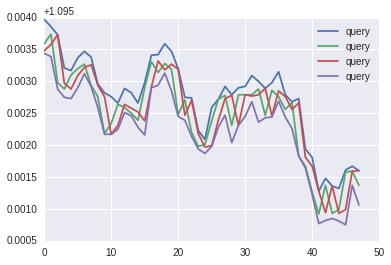

SUGGESTIONS


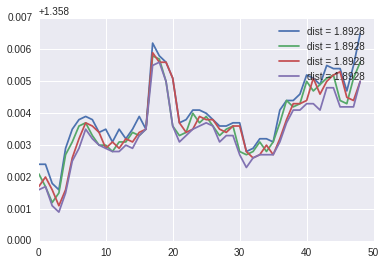

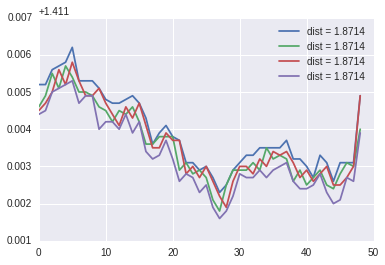

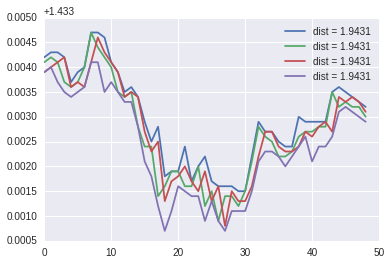

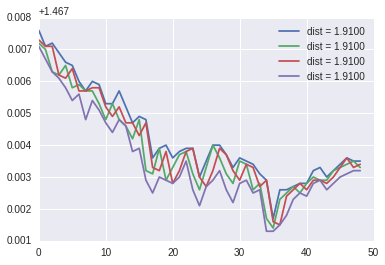

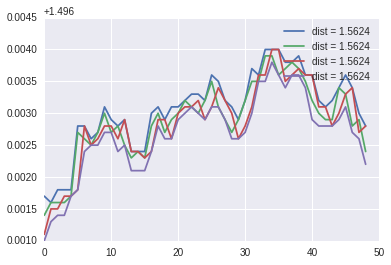

********************************************************************************
QUERY


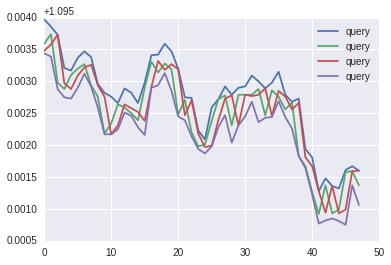

EXTENDED QUERY


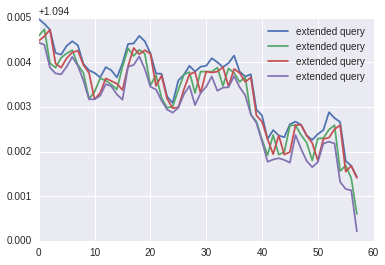

SUGGESTIONS


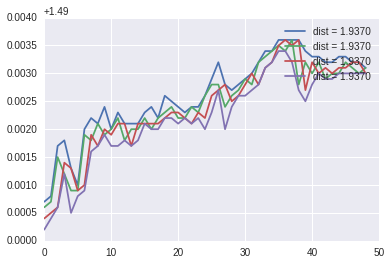

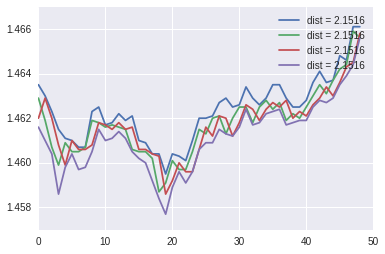

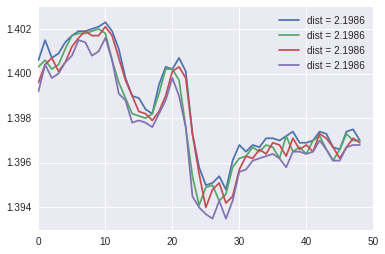

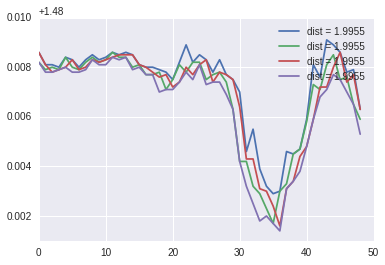

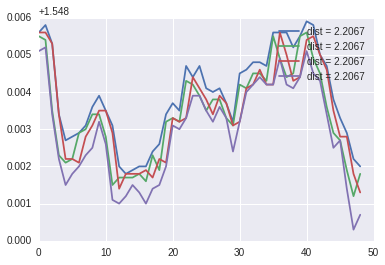

In [201]:
print("QUERY")
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()
print("SUGGESTIONS")
for n in range(len(ret)):
    plt.plot(df[ret[n]["start"]:ret[n]["end"]],label="dist = %.04f"%(ret[n]["distance"]))
    plt.legend()
    plt.show()
    
print("*"*80)
    
print("QUERY")
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()
print("EXTENDED QUERY")
tmp_df = df[start:]
tmp_end = max(tmp_df.index.get_loc(end),20)
plt.plot(tmp_df.iloc[:tmp_end+10+1],label="extended query")
plt.legend()
plt.show()
print("SUGGESTIONS")
for n in range(len(ret2)):
    plt.plot(df[ret2[n]["start"]:ret2[n]["end"]],label="dist = %.04f"%(ret2[n]["distance"]))
    plt.legend()
    plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

In [8]:
from tseries.converter import Converter
from tseries.indicators import get_functions
import copy

In [96]:
def search(mp, start, end, samples=10000, k_nearest=5):

    s2 = time.time()
    s = time.time()
    
    from tseries.converter import Converter
    from tseries.indicators import get_functions
    import histdata
    import copy

    mp = copy.deepcopy(mp)

    conv = Converter(
        get_functions(
            #_remove_duplicates(_remove_normalizers(mp['features'])),
            take,
            mp['timeframe'],
            mp['version'],
        ))

    h5 = histdata.get_pandadb()
    df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]
    selected_range = df.ix[
        df.index.get_loc(start) - (conv.window_size - 1):][:end]
    range_size = selected_range.shape[0] - conv.window_size

    print("Data load:",time.time() - s2)
    s2 = time.time()
    
    splits = 5
    shift = len(df) - range_size * samples
    # * k_nearest?

    df = df[shift:]

    data = df[["close","high","low","open"]].values
    query = selected_range[["close","high","low","open"]].values
    
    # calculate features
    #tgt = _fetch_features(conv, df.ix[-range_size * samples:], range_size)
    #src = _fetch_features(conv, selected_range, range_size)
    #ttgt = _fff(conv, df.ix[-range_size * samples:], range_size)
    #ssrc = _fff(conv, selected_range, range_size)
    #query = ssrc

    sp = split(data,fold=splits)
    #sp = split(ttgt,fold=splits)
    
    print("Split:",time.time() - s2)
    s2 = time.time()
    
    
    

    
    
    
    
    
    
    idx = []

    pool = Pool(5)
    dic = {}
    for i in range(splits):
        dic["result%d"%i] = pool.apply_async(_ucrdtw.ucrdtw, [sp[i],query,0.01,True])
        
    print("Pool and DTW",time.time() - s2)
    s2 = time.time()
    
    for i in dic.iteritems():
        loc,dist = i[1].get(timeout=3)

        idx.append({
            'start': df.ix[loc].name,
            'end': df.ix[loc + range_size].name,
            'distance': dist,
            'num_candles': range_size
        })
        
    print("Dic and Merge",time.time() - s2)
    
    logger.info("elapsed time till FastICA: {}".format(time.time() - s))

    return idx

In [243]:
%%time
#start, end = "2015-01-02 08:00:00" , "2015-01-02 08:55:00"
start, end = "2015-04-02 10:30:00" , "2015-04-02 11:55:00"
ret = search(mp,start,end)

Data load: 0.863708019257
Split: 0.0125699043274
Pool and DTW 0.309451818466
Dic 0.173883914948
CPU times: user 232 ms, sys: 976 ms, total: 1.21 s
Wall time: 1.37 s


In [244]:
ret

[{'distance': 7.620522270116385e-08,
  'end': Timestamp('2011-08-26 07:40:00+0000', tz='UTC'),
  'num_candles': 17,
  'start': Timestamp('2011-08-26 06:15:00+0000', tz='UTC')},
 {'distance': 4.6964558088671735,
  'end': Timestamp('2011-11-29 08:20:00+0000', tz='UTC'),
  'num_candles': 17,
  'start': Timestamp('2011-11-29 06:55:00+0000', tz='UTC')},
 {'distance': 4.654255072203616,
  'end': Timestamp('2011-11-11 21:25:00+0000', tz='UTC'),
  'num_candles': 17,
  'start': Timestamp('2011-11-11 20:00:00+0000', tz='UTC')},
 {'distance': 3.9834035990120236,
  'end': Timestamp('2011-10-18 06:35:00+0000', tz='UTC'),
  'num_candles': 17,
  'start': Timestamp('2011-10-18 05:10:00+0000', tz='UTC')},
 {'distance': 5.087743337357065,
  'end': Timestamp('2011-12-12 03:30:00+0000', tz='UTC'),
  'num_candles': 17,
  'start': Timestamp('2011-12-12 02:05:00+0000', tz='UTC')}]

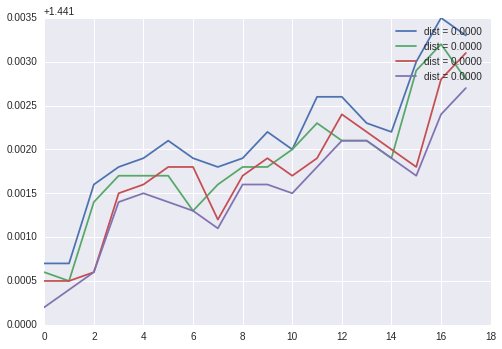

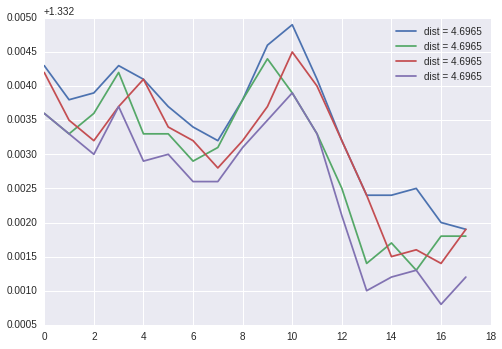

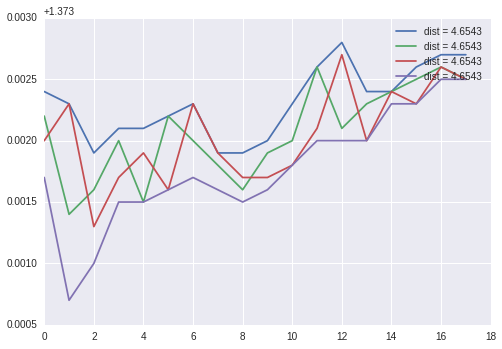

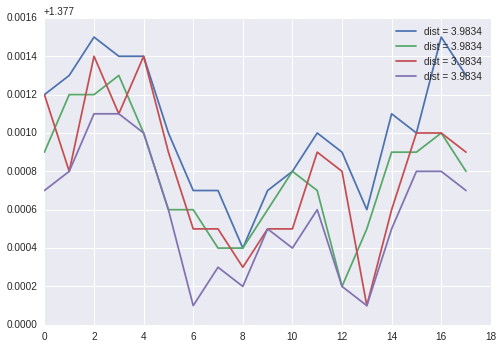

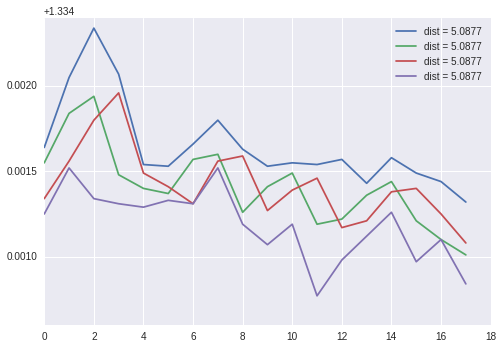

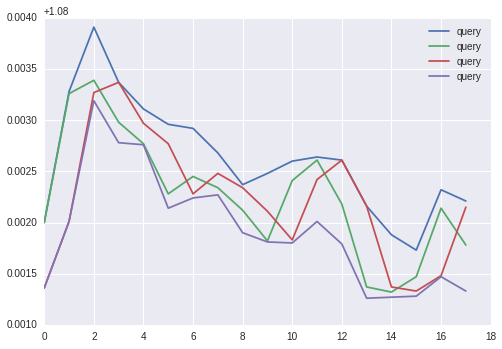

In [245]:
for n in range(len(ret)):
    plt.plot(df[ret[n]["start"]:ret[n]["end"]],label="dist = %.04f"%(ret[n]["distance"]))
    plt.legend()
    plt.show()
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()

In [84]:
np.shape(ttgt)

(349801, 10)

In [85]:
np.shape(ssrc)

(36, 10)

In [79]:
def _fff(conv, df, range_size):
        logger.info("applying the converter to timeseries data")
        data = []
        for r in conv.apply_stream(df, 1000 * 1000):
            data.append(r)

        return data

In [16]:
%%time

samples = 10000
pca_dim=32
k_nearest=5

conv = Converter(
    get_functions(
        _remove_duplicates(_remove_normalizers(mp['features'])),
        mp['timeframe'],
        mp['version'],
    ))

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]
selected_range = df.ix[
    df.index.get_loc(start) - (conv.window_size - 1):][:end]
range_size = selected_range.shape[0] - conv.window_size

#if range_size == 0:
#    return []

if df.shape[0] < samples * range_size:
    samples = df.shape[0] // range_size

s = time.time()

# calculate features
tgt = _fetch_features(conv, df.ix[-range_size * samples:], range_size)
src = _fetch_features(conv, selected_range, range_size)

#ttgt = _fff(conv, df.ix[-range_size * samples:], range_size)
#ssrc = _fff(conv, selected_range, range_size)


print(time.time() - s)

# PCA Compression
logger.info("applying FastICA")
ica = FastICA(pca_dim)
ica.fit(tgt + src)
vec_tgt = ica.transform(tgt)
vec_src = ica.transform(src)

print(time.time() - s)

idx = []
for i in np.array([
        np.linalg.norm(vec_src - x)
        for x in vec_tgt]).argsort()[: k_nearest]:

    idx.append({
        'start': df.ix[i * range_size - range_size * samples].name,
        'end': df.ix[(i * range_size - range_size * samples) + range_size].name,
        'distance': np.linalg.norm(vec_src - vec_tgt[i]),
        'num_candles': range_size
    })
    
print(time.time() - s)

logger.info("elapsed time till FastICA: {}".format(time.time() - s))


# Once took: !!!!!
# 6.6968100071
# 19.9821951389
# 20.0497951508
# CPU times: user 20.1 s, sys: 448 ms, total: 20.5 s
# Wall time: 20.3 s

1.1378929615
4.13935995102
4.21045899391


In [238]:
idx

[{'distance': 0.04826406412276818,
  'end': Timestamp('2015-10-01 02:30:00+0000', tz='UTC'),
  'num_candles': 35,
  'start': Timestamp('2015-09-30 23:35:00+0000', tz='UTC')},
 {'distance': 0.049279693156951181,
  'end': Timestamp('2012-08-20 19:50:00+0000', tz='UTC'),
  'num_candles': 35,
  'start': Timestamp('2012-08-20 16:55:00+0000', tz='UTC')},
 {'distance': 0.05000671265210236,
  'end': Timestamp('2016-01-06 07:15:00+0000', tz='UTC'),
  'num_candles': 35,
  'start': Timestamp('2016-01-06 04:20:00+0000', tz='UTC')},
 {'distance': 0.050312311729960438,
  'end': Timestamp('2015-12-18 03:05:00+0000', tz='UTC'),
  'num_candles': 35,
  'start': Timestamp('2015-12-18 00:10:00+0000', tz='UTC')},
 {'distance': 0.050871518113483338,
  'end': Timestamp('2014-11-07 13:45:00+0000', tz='UTC'),
  'num_candles': 35,
  'start': Timestamp('2014-11-07 10:50:00+0000', tz='UTC')}]

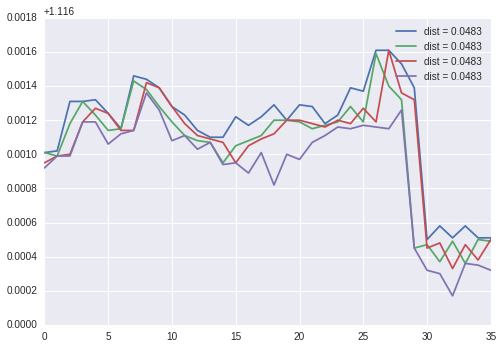

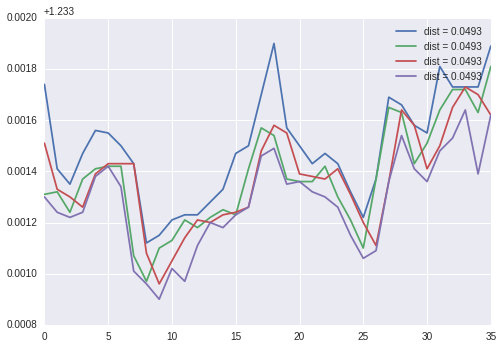

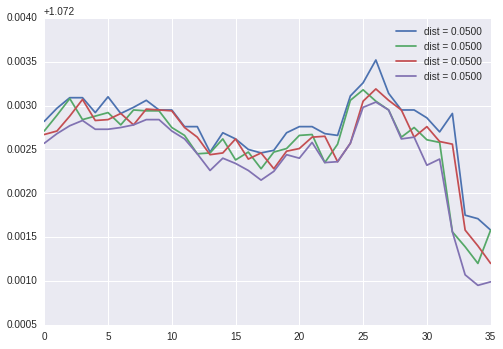

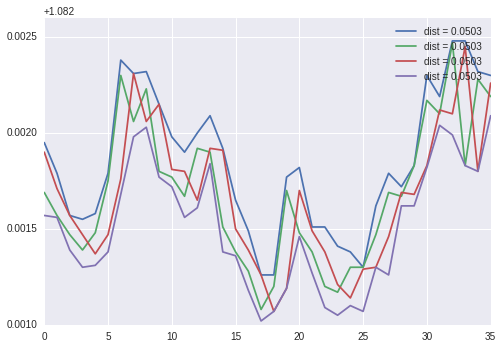

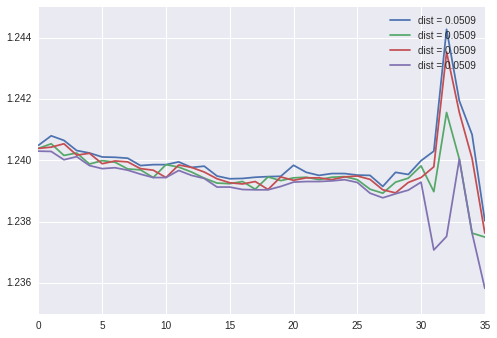

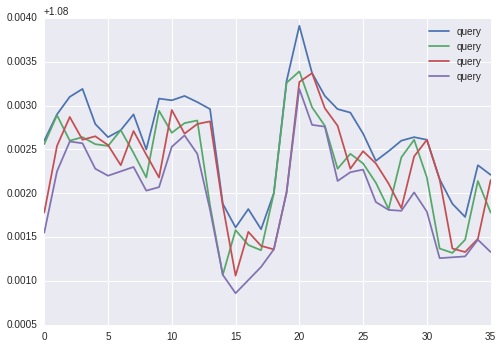

In [239]:
for n in range(len(idx)):
    plt.plot(df[idx[n]["start"]:idx[n]["end"]],label="dist = %.04f"%(idx[n]["distance"]))
    plt.legend()
    plt.show()
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()

In [15]:
np.array([
        np.linalg.norm(vec_src - x)
        for x in vec_tgt]).argsort()[: k_nearest]

array([15872, 24277, 25027, 25032, 21638])

In [141]:
%%timeit

s = time.time()


conv = Converter(
    get_functions(
        take,
        mp['timeframe'],
        mp['version'],
    ))

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]
selected_range = df.ix[
    df.index.get_loc(start) - (conv.window_size - 1):][:end]
range_size = selected_range.shape[0] - conv.window_size

#if range_size == 0:
#    return []

#if df.shape[0] < samples * range_size:
#    samples = df.shape[0] // range_size

print("get the data",time.time() - s)
s = time.time()


splits = 5
shift = len(df) - range_size * samples


df = df[shift:]


dt = []
for r in conv.apply_stream(df, 1000 * 1000):
    dt.append(r)
    
dt2 = []
for r in conv.apply_stream(selected_range, 1000 * 1000):
    dt2.append(r)

#data = df[["close","high","low","open"]].values
#query = selected_range[["close","high","low","open"]].values
data = dt
query = dt2
sp = split(data,fold=splits)

print("slice",time.time() - s)
s = time.time()

idx = []

pool = Pool(5)
dic = {}
for i in range(splits):
    dic["result%d"%i] = pool.apply_async(_ucrdtw.ucrdtw, [sp[i],query,0.01,True])
    
for i in dic.iteritems():
    loc,dist = i[1].get(timeout=3)
    
    idx.append({
        'start': df.ix[loc].name,
        'end': df.ix[loc + range_size].name,
        'distance': dist,
        'num_candles': range_size
    })

#args = [[i,query,0.01,True] for i in sp]
#results = pool.map(fu, sp)
    
print("DTW",time.time() - s)

#logger.info("elapsed time till FastICA: {}".format(time.time() - s))

get the data 0.331754922867
slice 0.331600904465
DTW 0.68492603302
get the data 0.401869058609
slice 0.425997972488
DTW 0.640576124191
get the data 0.465149879456
slice 0.399170160294
DTW 0.587117195129
get the data 0.266781806946
slice 0.312332868576
DTW 0.748888969421
1 loop, best of 3: 1.33 s per loop


In [164]:

conv = Converter(
    get_functions(
        take,
        mp['timeframe'],
        mp['version'],
    ))

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]
selected_range = df.ix[
    df.index.get_loc(start) - (conv.window_size - 1):][:end]
range_size = selected_range.shape[0] - conv.window_size



splits = 5
shift = len(df) - range_size * samples


df = df[shift:]

data = df[["close"]].values
query = selected_range[["close"]].values

sp = split(data,fold=splits)

idx = []

pool = Pool(5)
dic = {}
for i in range(splits):
    dic["result%d"%i] = pool.apply_async(_ucrdtw.ucrdtw, [sp[i],query,0.01,True])
    
for i in dic.iteritems():
    loc,dist = i[1].get(timeout=3)
    
    idx.append({
        'start': df.ix[loc].name,
        'end': df.ix[loc + range_size].name,
        'distance': dist,
        'num_candles': range_size
    })

#logger.info("elapsed time till FastICA: {}".format(time.time() - s))

get the data 0.334875106812
slice 0.0345940589905
DTW 0.399569034576
CPU times: user 224 ms, sys: 552 ms, total: 776 ms
Wall time: 770 ms


In [135]:
take = [
 {u'id': u'close_dg1', u'indicator_type': u'Identity', u'name': u'close'},
 {u'id': u'umustache', u'indicator_type': u'UMustache'},
 {u'field': u'close',
  u'id': u'ma-1',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 75},
 {u'field': u'close',
  u'id': u'ma-2',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 200},
 {u'fast_ma_period': 12,
  u'id': u'macd-3',
  u'indicator_type': u'MACD',
  u'mode': u'macd',
  u'signal_period': 9,
  u'slow_ma_period': 26}]

In [90]:
take = [
 {u'id': u'close_dg1', u'indicator_type': u'Identity', u'name': u'close'},
 {u'id': u'umustache', u'indicator_type': u'UMustache'},
 {u'field': u'close',
  u'id': u'ma-1',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 75},
 {u'fast_ma_period': 12,
  u'id': u'macd-3',
  u'indicator_type': u'MACD',
  u'mode': u'macd',
  u'signal_period': 9,
  u'slow_ma_period': 26}]

In [130]:
take

[{u'id': u'umustache', u'indicator_type': u'UMustache'},
 {u'id': u'lmustache', u'indicator_type': u'LMustache'},
 {u'field': u'close',
  u'id': u'ma-1',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 75},
 {u'field': u'close',
  u'id': u'ma-2',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 200},
 {u'fast_ma_period': 12,
  u'id': u'macd-3',
  u'indicator_type': u'MACD',
  u'mode': u'macd',
  u'signal_period': 9,
  u'slow_ma_period': 26},
 {u'fast_ma_period': 12,
  u'id': u'macd-3-signal',
  u'indicator_type': u'MACD',
  u'mode': u'macdsignal',
  u'signal_period': 9,
  u'slow_ma_period': 26}]

In [117]:
mmp = copy.deepcopy(mp)

In [128]:
_remove_duplicates(_remove_normalizers(mmp['features']))

[{u'id': u'open_dg1', u'indicator_type': u'Identity', u'name': u'open'},
 {u'id': u'high_dg1', u'indicator_type': u'Identity', u'name': u'high'},
 {u'id': u'low_dg1', u'indicator_type': u'Identity', u'name': u'low'},
 {u'id': u'close_dg1', u'indicator_type': u'Identity', u'name': u'close'},
 {u'id': u'umustache', u'indicator_type': u'UMustache'},
 {u'id': u'lmustache', u'indicator_type': u'LMustache'},
 {u'field': u'close',
  u'id': u'ma-1',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 75},
 {u'field': u'close',
  u'id': u'ma-2',
  u'indicator_type': u'MA',
  u'mode': u'simple',
  u'offset': 0,
  u'window_size': 200},
 {u'fast_ma_period': 12,
  u'id': u'macd-3',
  u'indicator_type': u'MACD',
  u'mode': u'macd',
  u'signal_period': 9,
  u'slow_ma_period': 26},
 {u'fast_ma_period': 12,
  u'id': u'macd-3-signal',
  u'indicator_type': u'MACD',
  u'mode': u'macdsignal',
  u'signal_period': 9,
  u'slow_ma_period': 26}]

In [124]:
mmmp = []
for i in _remove_duplicates(_remove_normalizers(mmp['features'])):
    if "open_dg1" in i:
        print(i)

In [98]:
df[199:200]

,high,close,open,low
2014-09-01 10:50:00+00:00,1.31402,1.31402,1.3139,1.31373


In [103]:
dt[0]

[1.3139,
 1.31402,
 1.3137299999999998,
 1.31402,
 0.0,
 0.00017000000000022553,
 1.3131924000000008,
 1.3132328000000002,
 0.00019292776231516484,
 0.0002483977341616201]

In [104]:
features

[u'open_dg1',
 u'high_dg1',
 u'low_dg1',
 u'close_dg1',
 u'open_dg2',
 u'high_dg2',
 u'low_dg2',
 u'close_dg2',
 u'umustache',
 u'lmustache',
 u'ma-1',
 u'ma-2',
 u'macd-3',
 u'macd-3-signal']

In [ ]:

for idx,i in enumerate(features[8:]):
    #print(i[0]+8,i)
    df.loc[:,i] = pd.Series(raw_store[:][:,idx+8], index=df.index)

In [80]:
%%time
tgt = _ffetch_features(conv, df.ix[-range_size * samples:], range_size)

CPU times: user 368 ms, sys: 16 ms, total: 384 ms
Wall time: 352 ms


In [446]:
idx

[{'distance': 0.02305578035590632,
  'end': Timestamp('2014-12-31 17:25:00+0000', tz='UTC'),
  'num_candles': 11,
  'start': Timestamp('2014-12-31 16:30:00+0000', tz='UTC')}]

In [475]:
ret = split(df)

In [466]:
%%timeit
a = df[:len(df)/4]
b = df[len(df)/4:2*len(df)/4]
c = df[2*len(df)/4:3*len(df)/4]
d = df[3*len(df)/4:]

1000 loops, best of 3: 333 µs per loop


In [419]:
%%time
data = df[["close"]].values
#query = seq[186][["close","high","low","open"]].values
query = selected_range[["close"]].values
loc,dist = _ucrdtw.ucrdtw(data, query, 0.01, True)
print(loc,dist)

1038379 2.33396313205e-08
CPU times: user 304 ms, sys: 4 ms, total: 308 ms
Wall time: 306 ms


In [161]:
mp = load_json("/project/exp/list_mp.json")

In [8]:
start, end = "2015-01-02 08:00:00" , "2015-01-02 08:55:00"

In [9]:
mp = copy.deepcopy(mp)

conv = Converter(
    get_functions(
        _remove_duplicates(_remove_normalizers(mp['features'])),
        mp['timeframe'],
        mp['version'],
    ))

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]
#selected_range = df.ix[
#    df.index.get_loc(start) - (conv.window_size - 1):][:end]
selected_range = df.ix[df.index.get_loc(start):][:end]
range_size = selected_range.shape[0] - conv.window_size

In [99]:
## adding indicators, ignore this

mp = load_json("/project/exp/list_mp.json")

conv = Converter(
    get_functions(
        mp['features'],
        mp['timeframe'],
        mp['version'],
    ))

for i in mp["features"]:
    i.pop("normalizers")

#[(i["id"],[j["normalizer_type"] for j in i["normalizers"]]) for i in mp['features']]
features = [i["id"] for i in mp['features']]

g = conv.apply_stream(df,10000)
raw_store = []
try:
    while(not(raw_store.append(g.next()))):
        continue
except StopIteration:
    print("over")

raw_store = np.array(raw_store)

df = df.tail(len(raw_store))

for idx,i in enumerate(features[8:]):
    #print(i[0]+8,i)
    df.loc[:,i] = pd.Series(raw_store[:][:,idx+8], index=df.index)

over


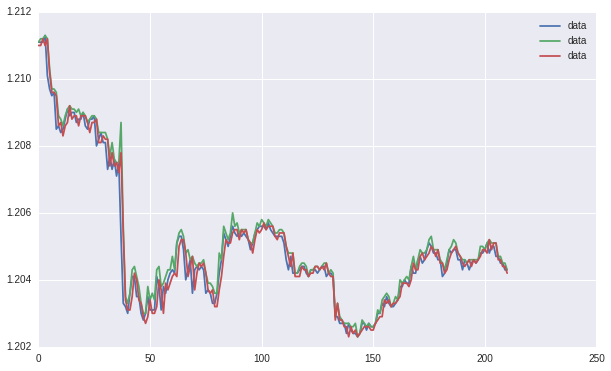

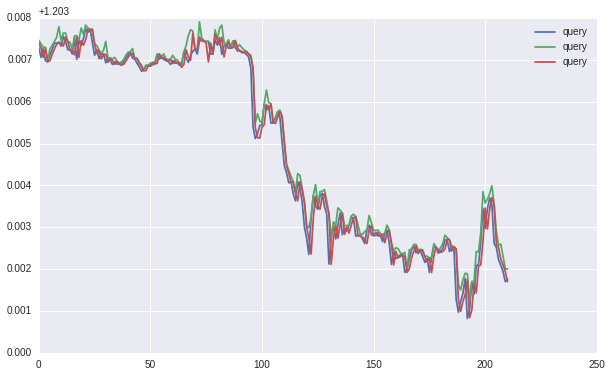

In [410]:
#r = np.random.randint(0,len(seq)-1)
#query = seq[r]
#loc,dist = get_best(df, query,fuzzy=0.05)
#print(loc,dist,r)

plt.figure()
plt.plot(data[loc:loc+len(query)],label="data")
plt.legend()
plt.show()

plt.figure()
plt.plot(query,label="query")
plt.legend()
plt.show()

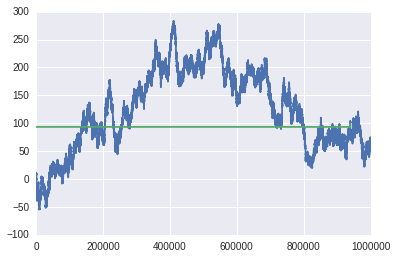

In [98]:
data = np.cumsum(np.random.uniform(-0.5, 0.5, 1000000))
query = np.cumsum(np.random.uniform(-0.5, 0.5, 100))
loc, dist = _ucrdtw.ucrdtw(data, query, 0.05, True)
query_m = np.concatenate((np.linspace(0.0, 0.0, loc), query)) + (data[loc] - query[0])

plt.figure()
plt.plot(data)
plt.plot(query_m)
plt.show()

28667 9.12760380377e-07


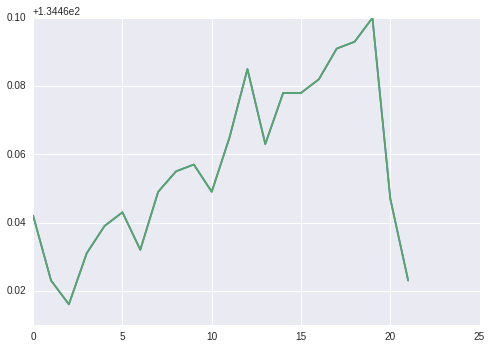

In [58]:
data, query = df["open"].values, seq[356]["open"].values
loc, dist = _ucrdtw.ucrdtw(data,query, 0.9, True)
print(loc,dist)
plt.figure()
plt.plot(data[loc:loc+len(query)])
plt.plot(query)
plt.show()

In [64]:
data, query = seq[347]["open"].values, seq[356]["open"].values
_ucrdtw.ucrdtw(data,query, 0.01, True)

(0L, 3.157274483223588)

28164 2.55758919634e-07


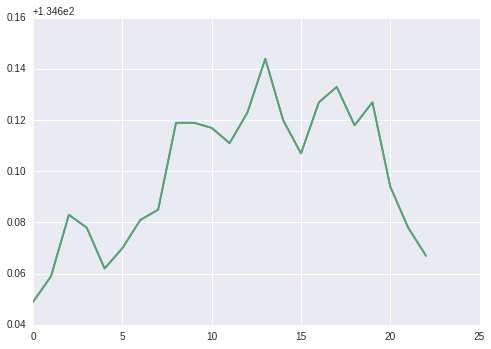

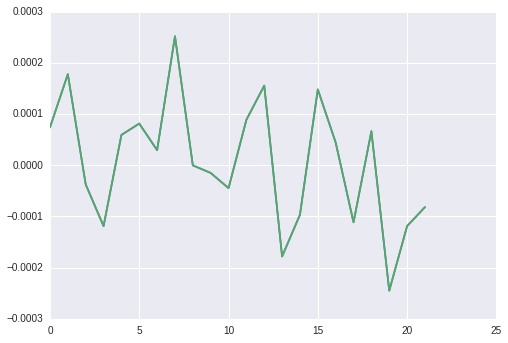

In [62]:
data, query = df["open"].values, seq[347]["open"].values
loc, dist = _ucrdtw.ucrdtw(data,query, 0.01, True)
print(loc,dist)
plt.figure()
plt.plot(data[loc:loc+len(query)])
plt.plot(query)
plt.show()
plt.figure()
plt.plot(norma(data[loc:loc+len(query)]))
plt.plot(norma(query))
plt.show()

In [193]:
data = norma(seq[0].values)
query = norma(seq[1].values)
_ucrdtw.ucrdtw(data, query, 0.05, True)

(15L, 0.06415808754682266)

In [218]:
%%time
# ~2min -> 15s

sim = []
for it in itertools.combinations(range(len(seq)),2):
    #a,b = norma(seq[it[0]]["open"].values) , norma(seq[it[1]]["open"].values)
    #a,b = seq[it[0]][["close","high","low","open"]].values , seq[it[1]][["close","high","low","open"]].values
    a,b = seq[it[0]][["open"]].values , seq[it[1]][["open"]].values

    #small series are unsignificant for dtw
    if len(a)>25 and len(b)>25 and len(a)<50 and len(b)<50:
        #data, query = seq[347]["open"].values, seq[356]["open"].values
        #a,b = norma(a),norma(b)
        loc, dist = _ucrdtw.ucrdtw(a,b, 0.01, True)
        #fdtw = fastdtw.fastdtw(a,b)
        sim.append([ dist,
                    it[0],
                    it[1]
                   ])
sim.sort(key=lambda x:x[0])

CPU times: user 59.7 s, sys: 780 ms, total: 1min
Wall time: 1min


In [121]:
%load_ext Cython

In [122]:
%%cython
cimport cython
from libc.math cimport exp, sqrt, pow, log, erf

@cython.cdivision(True)
cdef double std_norm_cdf(double x) nogil:
    return 0.5*(1+erf(x/sqrt(2.0)))

@cython.cdivision(True)
def black_scholes(double s, double k, double t, double v,
                 double rf, double div, double cp):
    """Price an option using the Black-Scholes model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    div : dividend
    cp : +1/-1 for call/put
    """
    cdef double d1, d2, optprice
    with nogil:
        d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
        d2 = d1 - v*sqrt(t)
        optprice = cp*s*exp(-div*t)*std_norm_cdf(cp*d1) - \
            cp*k*exp(-rf*t)*std_norm_cdf(cp*d2)
    return optprice

In [123]:
black_scholes(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)

10.327861752731728

In [124]:
%timeit black_scholes(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)

The slowest run took 89.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 280 ns per loop


In [219]:
sim[:10]

[[1.3883415764724236, 61, 308],
 [1.4746720369146924, 317, 333],
 [1.5959401921937852, 297, 333],
 [1.6223365348716798, 185, 287],
 [1.627002384804283, 66, 77],
 [1.6348171149508688, 103, 369],
 [1.7710843515095995, 263, 333],
 [1.783866015451454, 59, 369],
 [1.8355893025039196, 299, 333],
 [1.8562408420325662, 90, 152]]

The two most similar labeled sequences here: 347 and 356

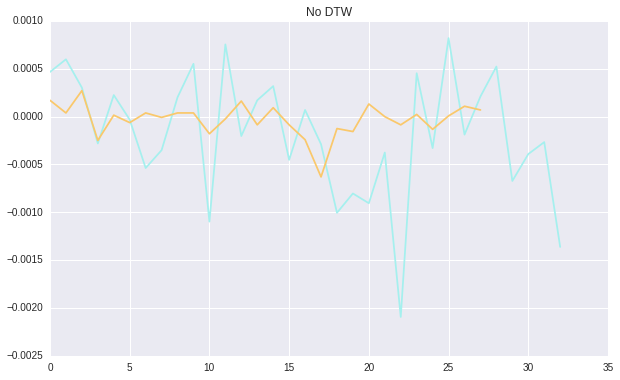

In [223]:
plt.plot(norma(seq[185]["open"].values),color="#A5F0EE")
plt.plot(norma(seq[287]["open"].values),color="#FAC86B")
plt.title("No DTW")
plt.show()

The 5 most similar sequences

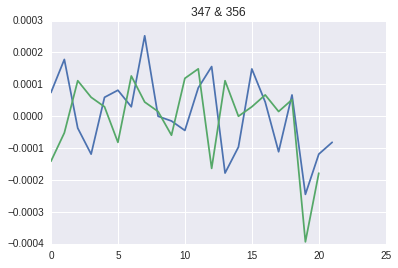

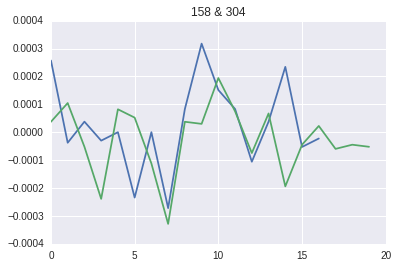

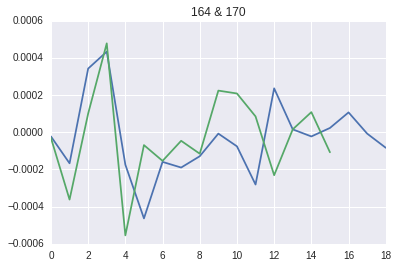

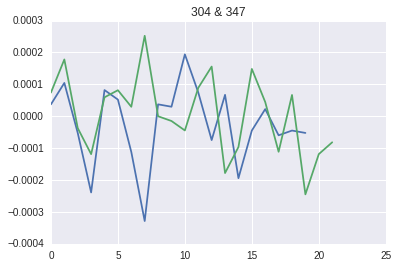

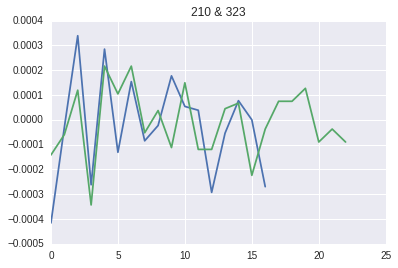

In [72]:
for i in sim[:5]:
    plt.plot(norma(seq[i[1]]["open"].values))
    plt.plot(norma(seq[i[2]]["open"].values))
    plt.title("%d & %d"%(i[1],i[2]))
    plt.show()

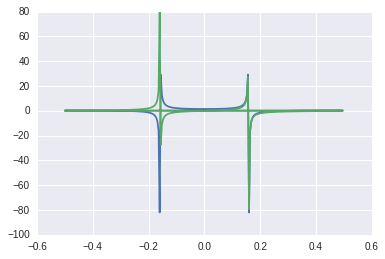

In [74]:
# docker exec -it 018fb4e0162c pip install fastdtw

x = np.array([5,1,1,4,1,1,3,5,1,4,1,1,2,3,4,1,4,1,1,1,1,1,1])
y = np.array([1,2,3,4,1,4,1])
fastdtw.fastdtw(x,y)

%matplotlib inline
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

plt.show()

In [75]:
## in progress

def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

x = np.random.random(8)
x = np.pad(x,[0,16-len(x)],mode="constant")
y = np.random.random(16)
rx = DFT_slow(x)
ry = DFT_slow(y)
print(x)
print(y)
print(rx)
print(ry)
#print(np.fft.ifft(rx))
rx*ry
#np.fft.rfft(x)


# pseudo-code from:
# http://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html

#def findNN(x,y):

x = np.array([1,1,1,1,1,1,2,3,4,1,4,1,1,1,1,1])
#x = np.array([1,2,3,4,1,4,1])*2
y = np.array([1,2,3,4,1,4,1])

#x is the data, y is the query
n = len(x)
#y = (y-np.mean(y))/np.std(y)                #Normalize the query
m = len(y)
x = np.append(x,np.zeros(n)) #x(n+1:2*n) = 0                                 #Append zeros
y = y[::-1]                  #y = y(end:-1:1)                                #Reverse the query
y = np.append(y,np.zeros(m)) #y(m+1:2*n) = 0                                 #Append zeros

#The main trick of getting dot products in O(n log n) time
y = np.pad(y,[0,len(x)-len(y)],mode="constant")
X = np.fft.fft(x)                                     #Change to Frequency domain
Y = np.fft.fft(y)                                     #Change to Frequency domain
## not element wise mult?? Z = X*Y
## cant do the inverse fourier transform if we .dot ...
Z = X*Y                                       #Do the dot product
#print(np.shape(Z))
#print(Z)
z = np.fft.ifft(Z)                                    #Come back to Time domain

#compute y stats -- O(n)
sumy = np.sum(y)
sumy2 = np.sum(y**2) #sum(y.^2)

#compute x stats -- O(n)
cum_sumx = np.cumsum(x)                           #Cumulative sums of x
cum_sumx2 = np.cumsum(x**2)                       #Cumulative sums of x^2
sumx2 = cum_sumx2[m+1:n]-cum_sumx2[1:n-m] #cum_sumx2(m+1:n)-cum_sumx2(1:n-m)      #Sum of x^2 of every subsequences of length m
sumx = cum_sumx[m+1:n]-cum_sumx[1:n-m] #cum_sumx(m+1:n)-cum_sumx(1:n-m)         #Sum of x of every subsequences of length m
meanx = sumx/float(m)                                #Mean of every subsequences of length m
sigmax2 = (sumx2/float(m))-(meanx**2)
sigmax = np.sqrt(sigmax2)                         #Standard deviaiton of every subsequences of length m


#computing the distances -- O(n) time.
#dist = (sumx2 - 2*sumx.*meanx + m*(meanx.^2))./sigmax2 - 2*(z(m+1:n) - sumy.*meanx)./sigmax + sumy2
#a = sumy.dot(meanx)/sigmax + sumy2

dist = (sumx2 - 2*sumx*meanx + m*(meanx**2))/sigmax2 - 2*(z[m+1:n] - sumy*meanx)/sigmax + sumy2
dist = np.sqrt(dist)

dist
    #return dist


[ 0.20306083  0.70658936  0.6142719   0.71095751  0.43754512  0.35212871
  0.69681478  0.79722211  0.          0.          0.          0.          0.
  0.          0.          0.        ]
[ 0.2535267   0.93123841  0.21762402  0.7870809   0.19575819  0.37893918
  0.38759547  0.74325752  0.69670053  0.90863801  0.70147669  0.28642275
  0.78251039  0.63446219  0.86775378  0.03779525]
[ 4.51859031 +0.00000000e+00j  0.19827830 -2.92227073e+00j
  0.07715553 -1.07100371e-01j -0.10477078 -1.47204833e+00j
 -0.67048073 +4.49461556e-01j  0.62762570 -4.92981996e-01j
 -0.54612411 -2.72186123e-01j  0.09111011 -1.93023938e-01j
 -0.61520507 -3.69971590e-16j  0.09111011 +1.93023938e-01j
 -0.54612411 +2.72186123e-01j  0.62762570 +4.92981996e-01j
 -0.67048073 -4.49461556e-01j -0.10477078 +1.47204833e+00j
  0.07715553 +1.07100371e-01j  0.19827830 +2.92227073e+00j]
[ 8.81077999 +0.00000000e+00j -0.78729024 +7.63318047e-01j
  0.34957076 -4.54951575e-01j -1.40050173 -4.83926559e-01j
 -0.24595415 -9.98721360e

array([ 7.61892401 +2.99895382e-15j,  6.88331260 +2.04749280e-15j,
        7.78396878 +3.46038073e-15j,  6.09191728 +3.16932423e-15j,
        7.78396878 +1.86239935e-15j,  7.24363016 +1.82700592e-15j,
        7.58484160 +1.10164247e-15j,  7.52548956 +5.48571972e-16j])

---
# Normalization

After lots of different experiments, a simple normalization seem to work better  
Simplest, fit into tanh range:

In [76]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([[[i]] for i in c]).astype(np.float32)
#cc = norm_and_center(seq[11]["open"].values)

---
# Experiments with a vanilla NN

In [77]:
hidden=15
class SimpleRNN(Chain):
    def __init__(self):
        super(SimpleRNN, self).__init__(
            l1 = L.Linear(1,hidden),
            l2 = L.LSTM(hidden,hidden),
            l3 = L.Linear(hidden,1),
        )
        
    def reset_state(self):
        self.l2.reset_state()
    
    def __call__(self,x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
        return h3

class Cla(Chain):
    def __init__(self, predictor):
        super(Cla, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
        #self.loss = np.abs(t - y) 
        #self.loss = np.power(np.abs(t - y) , 1.2)
        #self.loss = np.power(np.abs(t - y) , 1.1)
        #self.loss = F.gaussian_kl_divergence(y, t)
        #self.accuracy = F.accuracy(y, t)
        return self.loss

def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(Variable(cur_word), Variable(next_word))
        #loss += model(Variable(cuda.to_gpu(cur_word)),
        #              Variable(cuda.to_gpu(next_word)))
        #loss += model(cuda.to_gpu(cur_word), cuda.to_gpu(next_word))
    return loss

In [84]:
def train(rnn,model,optimizer,x_train,nb_epoch=100,print_every=-1,use_gpu=False):

    print_every = print_every if print_every!=-1 else nb_epoch/10
    
    predicted = []
    loss_log = []
    #
    #model.to_gpu()

    #cc = norm_and_center(seq[3]["open"].values)
    
    def compute_loss(x_list):
        loss = 0
        for cur_word, next_word in zip(x_list, x_list[1:]):
            if use_gpu:
                loss += model(Variable(cuda.to_gpu(cur_word)),
                              Variable(cuda.to_gpu(next_word)))
            else:
                loss += model(Variable(cur_word), Variable(next_word))
        return loss


    fig,ax = plt.subplots(1,1)
    #fig2,ax2 = plt.subplots(1,1)
    fig2,ax2 = plt.subplots(1,1)

    for i in tqdm.tqdm(range(nb_epoch),smoothing=0.1):
    #for i in range(nb_epoch):
        
        example = x_train[np.random.randint(len(x_train))]
        
        rnn.reset_state()
        model.zerograds()
        loss = compute_loss(example)
        loss.backward()
        optimizer.update()
        loss_log.append(loss.data)
        #loss_log.append(loss.data[0][0])

        # plot graphs
        if i%print_every == 0:
            #print("It: %s, Loss: %.16f"%(str(i).rjust(10) , loss.data) )
            rnn.reset_state()
            predicted = []
            for idx,j in enumerate(example[:-1]):     
                #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]))
                #predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
                predicted.append(model.predictor(Variable(j)).data)
            ax.clear()
            ax.plot([p[0][0] for p in example],label="True")
            ax.plot([p[0][0] for p in predicted],label="Pred at epoch %d"%(i))
            ax.legend()
            fig.canvas.draw()

            #ax2.clear()
            #ax2.plot(loss_log,label="Loss at %d"%i,color="red")
            #ax2.legend()
            #fig2.canvas.draw()
            #loss_log = []

    #print("over")
            #fig2,ax2 = plt.subplots(1,1)
            ax2.clear()
            ax2.plot(loss_log,label="Training loss\n(loss: %.3e)\n(logarithmic scale)"%(loss.data),color="red")
            ax2.set_yscale('log')
            ax2.legend()
            fig2.canvas.draw()
        

In [79]:
rnn = SimpleRNN()
model = Cla(rnn)
#model.to_gpu()
#optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)
#optimizer = optimizers.NesterovAG(lr=0.01, momentum=0.9)
optimizer = optimizers.AdaDelta()
#optimizer = optimizers.SGD(lr=0.02)
optimizer.setup(model)

### Let's first try to fit one pattern only:

<IPython.core.display.Javascript object>


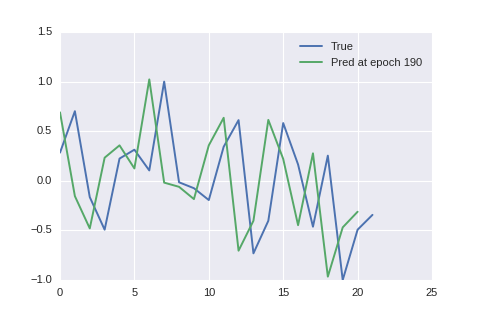

<IPython.core.display.Javascript object>


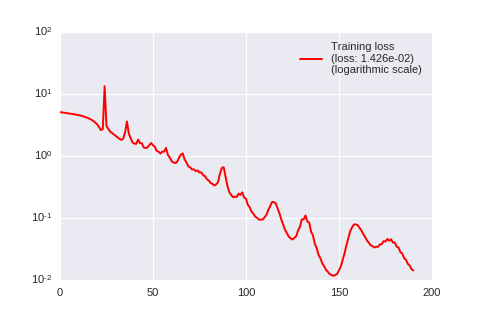

<IPython.core.display.Javascript object>


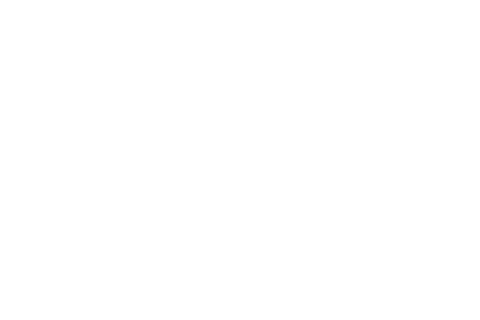

<IPython.core.display.Javascript object>


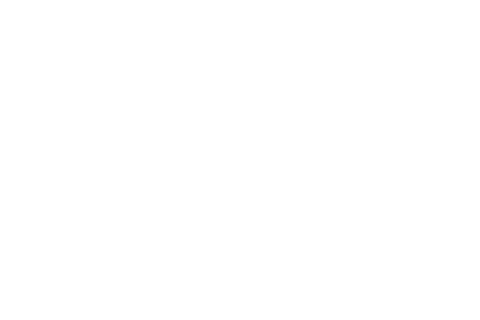

In [100]:
%matplotlib notebook
#347, 356, 323
x_train = [norm_and_center(seq[347]["open"].values,scale=100)]

rnn = SimpleRNN()
model = Cla(rnn)
optimizer = optimizers.AdaDelta()
optimizer.setup(model)

train(rnn,model,optimizer,x_train,nb_epoch=200,print_every=10,use_gpu=False)

It learn very quickly, the task is quite easy.  
How does it predict a known data? An unknown one?

In [101]:
def show_one_prediction(example):
    fig,ax = plt.subplots(1,1)
    rnn.reset_state()
    predicted = []
    for idx,j in enumerate(example[:-1]):     
        predicted.append(model.predictor(Variable(j)).data)
    #ax.clear()
    ax.plot([p[0][0] for p in example[1:]],label="True")
    ax.plot([p[0][0] for p in predicted],label="Prediciton (shifted)")
    ax.legend()
    fig.canvas.draw()

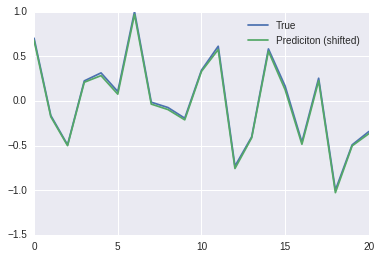

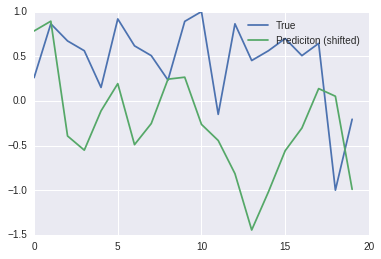

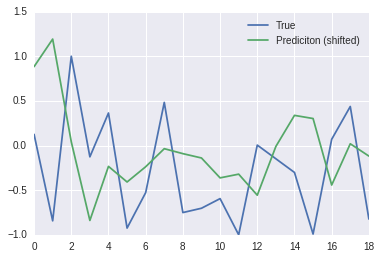

In [103]:
%matplotlib inline
show_one_prediction(norm_and_center(seq[347]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[356]["open"].values,scale=10))  # related data
show_one_prediction(norm_and_center(seq[45]["open"].values,scale=10))   # unrelated

Not good in either case.  
With different training data?

<IPython.core.display.Javascript object>


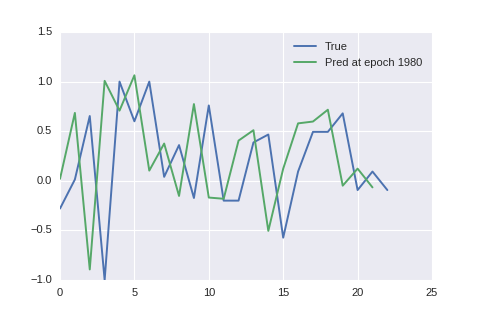

<IPython.core.display.Javascript object>


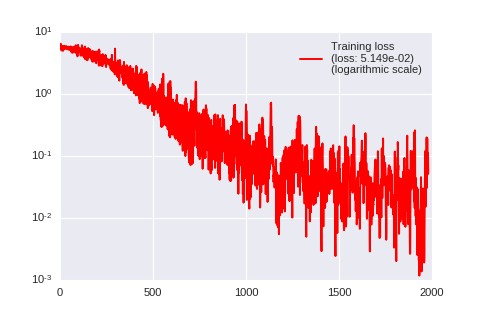

<IPython.core.display.Javascript object>


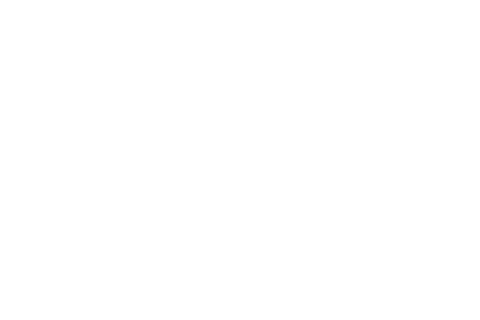

<IPython.core.display.Javascript object>


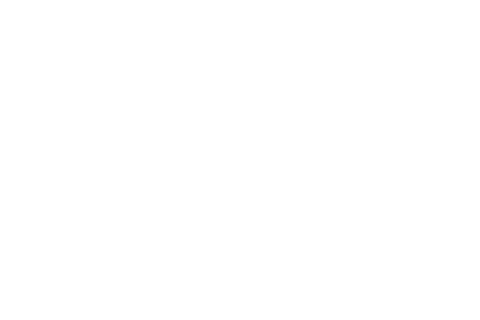

In [109]:
%matplotlib notebook
#347, 356, 323
x_train = [norm_and_center(seq[347]["open"].values,scale=100),
          norm_and_center(seq[356]["open"].values,scale=100),
          norm_and_center(seq[323]["open"].values,scale=100)]

rnn = SimpleRNN()
model = Cla(rnn)
optimizer = optimizers.AdaDelta()
optimizer.setup(model)

train(rnn,model,optimizer,x_train,nb_epoch=2000,print_every=20,use_gpu=False)

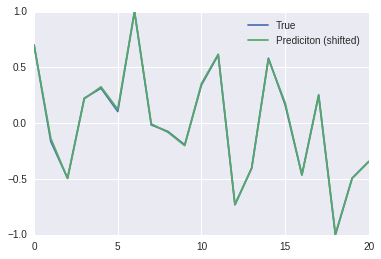

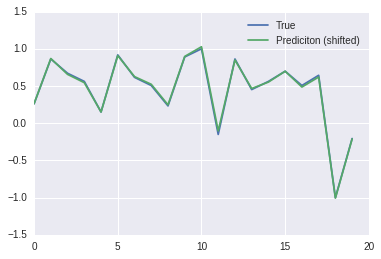

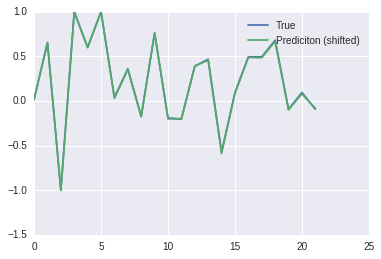

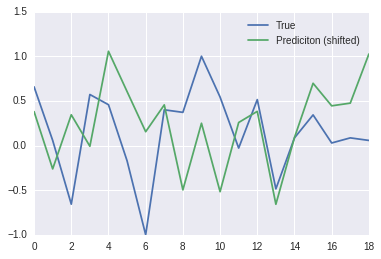

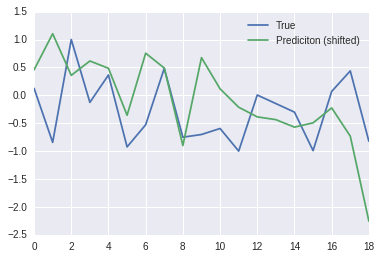

In [111]:
%matplotlib inline
show_one_prediction(norm_and_center(seq[347]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[356]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[323]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[304]["open"].values,scale=10))  # somehow related
show_one_prediction(norm_and_center(seq[45]["open"].values,scale=10))   # unrelated

Not better.  

---

The network is really good to memorize sequence quickly, and it is easier with more input dimensions.  
Next step, add the features and generalize from there

--- 




---



---


---

In [345]:
for idx,j in enumerate(cc[:-1]):     
    print(j[0][0])
    print(">>",model.predictor(Variable(j)).data[0][0])

0.283694
>> -0.874144
0.701675
>> -0.885138
-0.164253
>> -1.32254
-0.492726
>> -0.261942
0.223945
>> -0.682081
0.313505
>> -0.782773
0.104482
>> 0.273587
1.0
>> -0.566777
-0.0149551
>> -0.558535
-0.0746583
>> -0.571217
-0.194067
>> -0.0446074
0.343254
>> 0.177254
0.611813
>> -1.1428
-0.731261
>> -0.615131
-0.403023
>> 0.432242
0.582042
>> -0.109145
0.164136
>> -0.801306
-0.462683
>> 0.16594
0.253694
>> -1.25785
-1.0
>> -0.532839
-0.49267
>> -0.437808


In [ ]:
def train(rnn,model,optimizer,x_train,y_train,nb_epoch=100,print_every=-1,use_gpu=False):

    print_every = print_every if print_every==-1 else nb_epoch/10
    
    predicted = []
    loss_log = []
    #
    #model.to_gpu()

    cc = norm_and_center(seq[3]["open"].values)

    fig,ax = plt.subplots(1,1)
    #fig2,ax2 = plt.subplots(1,1)
    
    def compute_loss(x_list):
        loss = 0
        for cur_word, next_word in zip(x_list, x_list[1:]):
            if use_gpu:
                loss += model(Variable(cuda.to_gpu(cur_word)),
                              Variable(cuda.to_gpu(next_word)))
            else:
                loss += model(Variable(cur_word), Variable(next_word))
        return loss

    for i in range(nb_epoch):
        rnn.reset_state()
        model.zerograds()
        loss = compute_loss(cc)
        loss.backward()
        optimizer.update()
        loss_log.append(loss.data)

        # plot graphs
        if i%print_every == 0:
            print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )

            predicted = []
            for idx,j in enumerate(cc[:-1]):     
                #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
                #predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
                predicted.append(model.predictor(Variable(j)).data)
            ax.clear()
            ax.plot([p[0][0] for p in cc],label="True")
            ax.plot([p[0][0] for p in predicted],label="Pred at %d"%i)
            ax.legend()
            fig.canvas.draw()

            #ax2.clear()
            #ax2.plot(loss_log,label="Loss at %d"%i,color="red")
            #ax2.legend()
            #fig2.canvas.draw()

            #loss_log = []

    print("over")
    fig2,ax2 = plt.subplots(1,1)
    ax2.plot(loss_log,label="Training loss\n(logarithmic scale)",color="red")
    ax2.set_yscale('log')
    ax2.legend()
    plt.show()

    return loss_log

In [ ]:
fig2,ax2 = plt.subplots(1,1)
ax2.clear()
ax2.plot(loss_log,label="Loss at %d"%i,color="red")
ax2.legend()
fig2.canvas.draw()

<IPython.core.display.Javascript object>


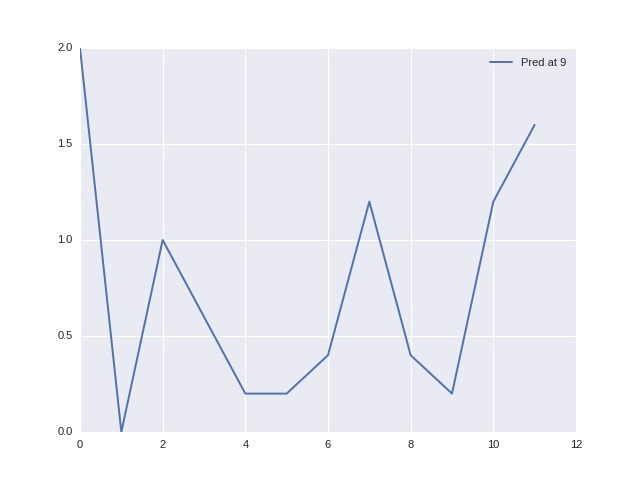

<IPython.core.display.Javascript object>


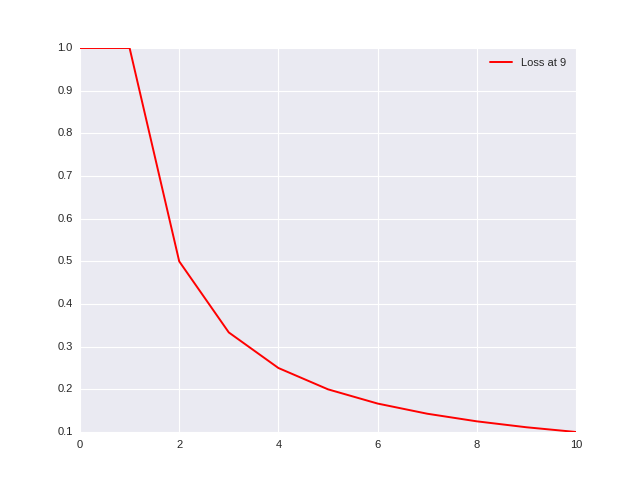

In [19]:
#%matplotlib notebook

import time

fig,ax = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)
predicted = [2,0]
p = [1]
for i in range(10):
    predicted.append(np.random.randint(1,10)/5.)
    ax.clear()
    ax.plot(predicted,label="Pred at %d"%i)
    ax.legend()
    fig.canvas.draw()
    
    p.append(1./(i+1))
    ax2.clear()
    ax2.plot(p,label="Loss at %d"%i,color="red")
    ax2.legend()
    ax2.set_yscale('log')
    fig2.canvas.draw()
    
    time.sleep(0.2)


In [279]:
hidden=15
class SimpleRNN(Chain):
    def __init__(self):
        super(SimpleRNN, self).__init__(
            l1 = L.Linear(1,hidden),
            l2 = L.LSTM(hidden,hidden),
            l3 = L.Linear(hidden,1),
        )
        
    def reset_state(self):
        self.l2.reset_state()
    
    def __call__(self,x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
        return h3

class Cla(Chain):
    def __init__(self, predictor):
        super(Cla, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
        #self.loss = F.softmax(y,t)
        #self.accuracy = F.accuracy(y, t)
        return self.loss

def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(Variable(cur_word), Variable(next_word))
        #loss += model(Variable(cuda.to_gpu(cur_word)),
        #              Variable(cuda.to_gpu(next_word)))
    return loss

In [289]:
rnn = SimpleRNN()
model = Cla(rnn)
#model.to_gpu()
optimizer = optimizers.MomentumSGD(lr=0.0001, momentum=0.9)
optimizer.setup(model)

In [292]:
def train(rnn,model,optimizer,x_train,y_train,nb_epoch=10):
    print_every = nb_epoch/10
    predicted = []
    #model.to_gpu()

    for i in range(nb_epoch):
        for idxj,j in enumerate(x_train):
            rnn.reset_state()
            model.zerograds()
            #loss = compute_loss(cc)

            x_list = j
            loss = 0
            for idx_list,cur_word in enumerate(x_list):
                loss += model(Variable(cur_word), Variable(y_train[idxj][idx_list]))
            loss.backward()
            optimizer.update()
        
        
        if i%print_every == 0:
            print(loss.data)
        #    print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )
train(rnn,model,optimizer,x_train,y_train,nb_epoch=100)

2.76180696487
2.74219655991
2.72951173782
2.71836495399
2.71101307869
2.70852565765
2.71127271652
2.71898365021
2.73087286949
2.74591135979


In [293]:
for idx,i in enumerate(x_train):
    print(model.predictor(Variable(x_train[idx][0])).data)
    print(y_train[idx][0])

[[-1.40001774]]
[[ 1.]]
[[-1.16897988]]
[[ 1.]]
[[-1.32574773]]
[[ 1.]]
[[-1.76312327]]
[[ 1.]]
[[-2.07155132]]
[[ 1.]]
[[-1.9925952]]
[[ 1.]]
[[-1.71506715]]
[[ 1.]]
[[-1.94466805]]
[[-1.]]
[[-1.60818863]]
[[-1.]]
[[-1.45551586]]
[[-1.]]
[[-1.78029084]]
[[-1.]]
[[-1.49156594]]
[[-1.]]
[[-1.44166589]]
[[-1.]]


In [286]:
model.predictor(Variable(x_train[0][0])).data

array([[ 2.46279144]], dtype=float32)

In [262]:
cut_at = np.array([len(i) for i in seq]).min()
x_train = []
for i in seq:
    c2 = i["open"].values
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    cc = np.array([[[i]] for i in c[:cut_at]]).astype(np.float32)
    x_train.append(cc)

In [263]:
y_train = np.array([[[[1]] for j in range(len(i))] for i in x_train]).astype(np.float32)

In [264]:
#cut_at = np.array([len(i) for i in seq]).min()
neg_x_train = []
for i in neg_seq:
    c2 = i["open"].values
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    cc = np.array([[[i]] for i in c[:cut_at]]).astype(np.float32)
    neg_x_train.append(cc)

In [265]:
neg_y_train = np.array([[[[-1]] for j in range(len(i))] for i in neg_x_train]).astype(np.float32)

In [266]:
x_train.extend(neg_x_train)
y_train = np.concatenate((y_train,neg_y_train), axis=0)

In [49]:
c2 = seq[1]["open"].values
c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
cc = np.array([[[i]] for i in c]).astype(np.float32)


nb_epoch = 200
print_every = nb_epoch/10
predicted = []
#model.to_gpu()

for i in range(nb_epoch):
    rnn.reset_state()
    model.zerograds()
    loss = compute_loss(cc)
    loss.backward()
    optimizer.update()
    if i%print_every == 0:
        print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )
        
        predicted = []
        for idx,j in enumerate(cc[:-1]):     
            #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
            predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
            #predicted.append(model.predictor(Variable(j)).data)

It:          0, Loss: 0.000069149
It:         20, Loss: 0.000044444
It:         40, Loss: 0.000028744
It:         60, Loss: 0.000018606
It:         80, Loss: 0.000012050
It:        100, Loss: 0.000007803
It:        120, Loss: 0.000005054
It:        140, Loss: 0.000003275
It:        160, Loss: 0.000002122
It:        180, Loss: 0.000001374


In [51]:
results = None
losss = []
#model.to_gpu()
model.zerograds()
for t in xrange(0, 100):
    #document = np.array([[[5]], [[4]], [[3]], [[2]], [[1]], [[2]], [[3]], [[4]], [[5]]]).astype(np.float32)
    document = cc
    optimizer.zero_grads()
    loss, results = forward(document)
    
    if t%10==0:
        print("It: %d, loss: %.02f"%(t,loss.data[0][0]))
        #print([i[0][0] for i in results])
        losss.append(loss.data[0][0])
        
        plt.gca().cla() 
        plt.plot([i[0][0] for i in cc],label="True")
        plt.plot([i[0][0] for i in results],label="Pred at %d"%t)
        plt.legend()

        display.display(plt.gcf()) 
        display.clear_output(wait=True)
    
    loss.backward()
    optimizer.update()

#print(["%.03f"%i[0][0] for i in results])
#print(["%.03f"%i[0][0] for i in cc])
plt.show()
plt.plot(losss,label="Loss")
plt.legend()
plt.show()
print("*-.-*")

AttributeError: 'Cla' object has no attribute 'Wx'

In [114]:
x = cuda.to_gpu(np.array([1,2]),device=0)

In [115]:
x.data

It: 00900, Loss: 0.001507


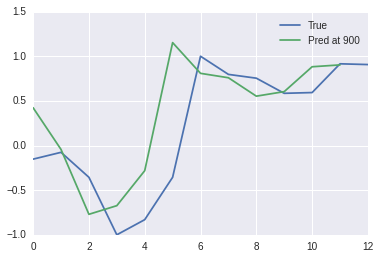

In [53]:
nb_epoch = 1000
predicted = []

for i in range(nb_epoch):
    rnn.reset_state()
    model.zerograds()
    loss = compute_loss(cc)
    loss.backward()
    optimizer.update()
    if i%100 == 0:
        
        predicted = []
        for idx,j in enumerate(cc[:-1]):     
            #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
            predicted.append(model.predictor(Variable(j)).data)
        plt.gca().cla() 
        plt.plot([p[0][0] for p in cc],label="True")
        plt.plot([p[0][0] for p in predicted],label="Pred at %d"%i)
        plt.legend()

        display.display(plt.gcf()) 
        display.clear_output(wait=True)
        
        print("It: %05d, Loss: %f"%(i , loss.data) )

In [185]:
for idx,i in enumerate(cc[:-1]):
    print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )

Pred 0.581, True -0.076
Pred 0.366, True -0.356
Pred -0.328, True -1.000
Pred -0.403, True -0.831
Pred -0.167, True -0.356
Pred -0.847, True 1.000
Pred 0.850, True 0.797
Pred 0.760, True 0.754
Pred 0.574, True 0.585
Pred 0.664, True 0.593
Pred 0.873, True 0.915
Pred 0.933, True 0.907


In [75]:
model.predictor(Variable(cc[0])).data

array([[ 0.09446953]], dtype=float32)

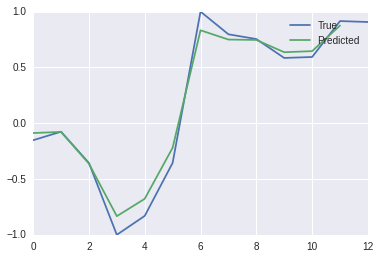

In [29]:
plt.plot([i[0][0] for i in cc],label="True")
plt.plot([i[0][0] for i in results],label="Predicted")
plt.legend()
plt.show()

In [30]:
print(["%.03f"%i[0][0] for i in results])
print(["%.03f"%i[0][0] for i in cc[1:]])

['-0.088', '-0.078', '-0.362', '-0.833', '-0.677', '-0.220', '0.833', '0.750', '0.746', '0.636', '0.646', '0.875']
['-0.076', '-0.356', '-1.000', '-0.831', '-0.356', '1.000', '0.797', '0.754', '0.585', '0.593', '0.915', '0.907']


In [ ]:
class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 100),
            l3=L.Linear(100, 10),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [ ]:
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

In [ ]:
model = L.Classifier(MLP())
optimizer = optimizers.SGD()
optimizer.setup(model)

In [ ]:
batchsize = 100
datasize = 60000  
for epoch in range(20):
    print('epoch %d' % epoch)
    indexes = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indexes[i : i + batchsize]])
        t = Variable(y_train[indexes[i : i + batchsize]])
        optimizer.update(model, x, t)

In [ ]:
batchsize = 100
datasize = 60000  
for epoch in range(20):
    print('epoch %d' % epoch)
    indexes = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indexes[i : i + batchsize]])
        t = Variable(y_train[indexes[i : i + batchsize]])
        model.zerograds()
        loss = model(x, t)
        loss.backward()
        optimizer.update()

In [ ]:
sum_loss, sum_accuracy = 0, 0
for i in range(0, 10000, batchsize):
    x = Variable(x_test[i : i + batchsize])
    t = Variable(y_test[i : i + batchsize])
    loss = model(x, t)
    sum_loss += loss.data * batchsize
    sum_accuracy += model.accuracy.data * batchsize
mean_loss = sum_loss / 10000
mean_accuracy = sum_accuracy / 10000

---

In [ ]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__(
            embed=L.EmbedID(1000, 100),  # word embedding
            mid=L.LSTM(100, 50),  # the first LSTM layer
            out=L.Linear(50, 1000),  # the feed-forward output layer
        )

    def reset_state(self):
        self.mid.reset_state()

    def __call__(self, cur_word):
        # Given the current word ID, predict the next word.
        x = self.embed(cur_word)
        h = self.mid(x)
        y = self.out(h)
        return y

rnn = RNN()
model = L.Classifier(rnn)
optimizer = optimizers.SGD()
optimizer.setup(model)

In [ ]:
def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(cur_word, next_word)
    return loss